MUSHROOM CLASSIFICATION WITH DECISION TREES
Fetching Secondary Mushroom Dataset from UCI ML Repository...
Dataset fetched successfully with 61069 samples and 20 features

Dataset Metadata:
Name: Secondary Mushroom
Abstract: Dataset of simulated mushrooms for binary classification into edible and poisonous....
Task: Classification

Using the full dataset with 61069 records

Dataset shape: (61069, 20)

Missing values:
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season    

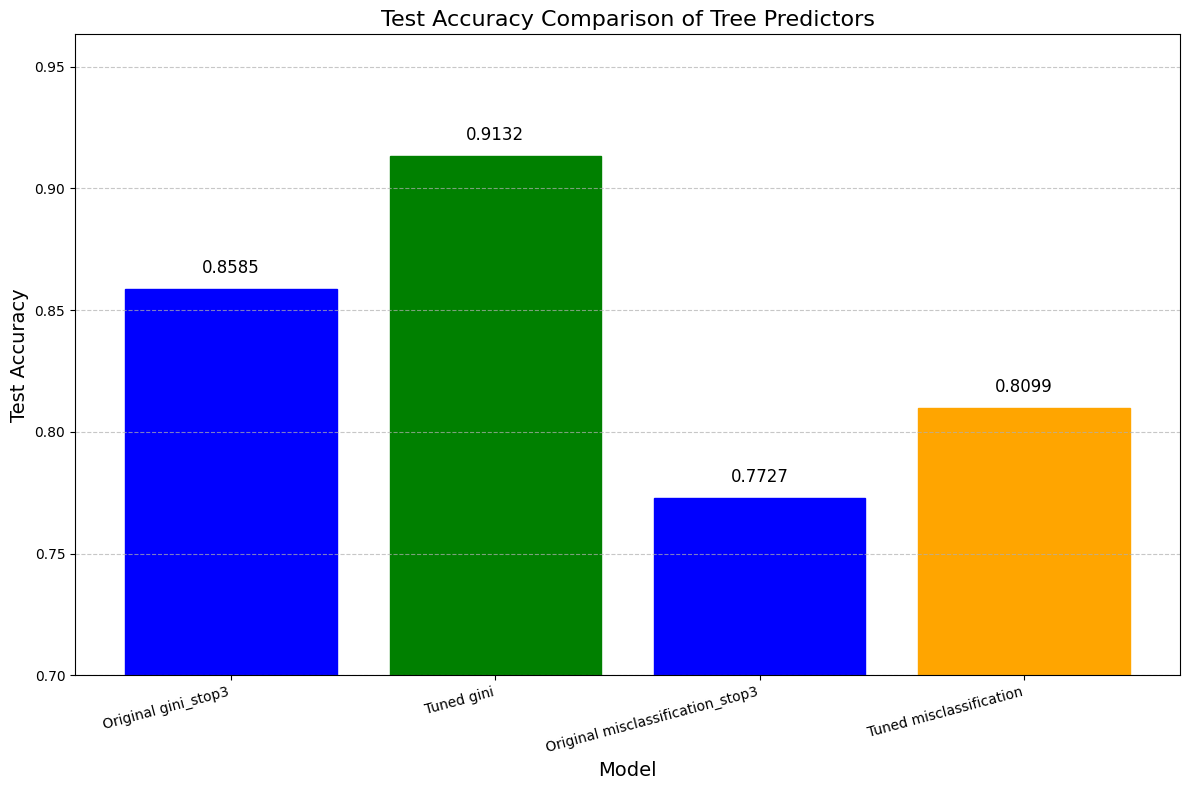

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import os
import time
import random
import warnings
from ucimlrepo import fetch_ucirepo


"""
Complete Mushroom Classification Analysis

This script implements the full mushroom classification workflow:
1. Fetches the dataset directly from UCI ML Repository
2. Initial training of all model configurations (gini, entropy, misclassification with different stopping criteria)
3. Hyperparameter tuning of gini_stop3 and misclassification_stop3 models
4. Visualization of decision trees for both untuned and tuned models
5. Performance comparison and evaluation

All random seeds are set for reproducibility.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import os
import time
import random
import warnings
from ucimlrepo import fetch_ucirepo

#suppress warnings
warnings.filterwarnings('ignore')

#random seeds for reproducibility
np.random.seed(42)
random.seed(42)

def fetch_mushroom_dataset():
    """
    Fetch the Secondary Mushroom Dataset from UCI ML Repository.
    
    Returns:
    --------
    X : pandas.DataFrame
        Feature dataframe
    y : pandas.DataFrame
        Target dataframe
    """
    print("Fetching Secondary Mushroom Dataset from UCI ML Repository...")
    
    # Fetch dataset with ID 848 (Secondary Mushroom Dataset)
    secondary_mushroom = fetch_ucirepo(id=848)
    
    #extracting features and target
    X = secondary_mushroom.data.features
    y = secondary_mushroom.data.targets
    
    print(f"Dataset fetched successfully with {X.shape[0]} samples and {X.shape[1]} features")
    
    #dataset metadata (safely accessing keys)
    print("\nDataset Metadata:")
    print(f"Name: {secondary_mushroom.metadata.get('name', 'Not available')}")
    print(f"Abstract: {secondary_mushroom.metadata.get('abstract', 'Not available')[:100]}...")
    print(f"Task: {secondary_mushroom.metadata.get('tasks', ['Not available'])[0] if secondary_mushroom.metadata.get('tasks') else 'Not available'}")
    
    return X, y

def handle_missing_values(df, strategy='mode'):
    """
    Handle missing values in the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    strategy : str
        The strategy to handle missing values ('mode', 'median', 'drop', 'indicator')
        
    Returns:
    --------
    df_processed : pandas.DataFrame
        The processed dataframe
    """
    df_processed = df.copy()
    
    if strategy == 'mode':
        # Filling missing values with mode for categorical features
        for col in df.select_dtypes(include=['object']).columns:
            mode_val = df[col].mode()[0]
            df_processed[col] = df_processed[col].fillna(mode_val)
            
        # Filling missing values with median for numerical features
        for col in df.select_dtypes(include=['number']).columns:
            median_val = df[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
    
    return df_processed

def create_tree_visualization(model, model_name, encoded_feature_names, improved=True):
    """
    Create a tree visualization
    """
    print(f"Creating visualization for {model_name}...")
    
    # Export tree visualization
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=encoded_feature_names,
        class_names=['edible', 'poisonous'],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=None,  #showing full tree
        proportion=True,  #showing proportions
        impurity=True,   #showing impurity
        precision=2      #precision for floating point numbers
    )
    
    if improved:
        dot_data = dot_data.replace(
            'digraph Tree {',
            'digraph Tree {\n'
            '    graph [rankdir=TB, splines=true, bgcolor="transparent"];\n'
            '    node [shape=ellipse, style="filled", color="black", fontname="helvetica"];\n'
            '    edge [fontname="helvetica", fontsize=10];'
        )
        
        dot_data = dot_data.replace('fillcolor="#399de5"', 'fillcolor="#8CCDF8"')
        dot_data = dot_data.replace('fillcolor="#e58139"', 'fillcolor="#CCCCCC"')
    
    dot_file = f"{model_name}.dot"
    with open(dot_file, 'w') as f:
        f.write(dot_data)
    
    # Converting to PNG with high resolution and large size
    os.system(f"dot -Tpng {dot_file} -o {model_name}.png -Gdpi=300 -Gsize=15,15")
    print(f"Visualization saved as {model_name}.png")
    
    # Also creating a PDF version for better quality in case its needed
    os.system(f"dot -Tpdf {dot_file} -o {model_name}.pdf")
    print(f"PDF version saved as {model_name}.pdf")

def train_initial_models(X_train, y_train, X_test, y_test, encoded_feature_names):
    """
    Train all initial models with different splitting and stopping criteria.
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training features
    y_train : numpy.ndarray
        Training target
    X_test : pandas.DataFrame
        Test features
    y_test : numpy.ndarray
        Test target
    encoded_feature_names : list
        List of feature names
        
    Returns:
    --------
    dict
        Dictionary containing all trained models and their results
    """
    print("\nTraining initial models with different configurations...")
    
    # Defining stopping criteria configurations
    stopping_criteria = {
        'stop1': {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1},
        'stop2': {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2},
        'stop3': {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}
    }
    
    # Storing the results
    results = {}
    
    # Train gini models
    for stop_name, stop_params in stopping_criteria.items():
        model_name = f"gini_{stop_name}"
        
        #creating and training the model
        model = DecisionTreeClassifier(
            criterion='gini',
            max_depth=stop_params['max_depth'],
            min_samples_split=stop_params['min_samples_split'],
            min_samples_leaf=stop_params['min_samples_leaf'],
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # Evaluating the model
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        # Storinf the results
        results[model_name] = {
            'model': model,
            'criterion': 'gini',
            'stopping_criteria': stop_params,
            'train_score': train_score,
            'test_score': test_score
        }
        
        # Printing the results
        print(f"\n{model_name}:")
        print(f"  Criterion: gini")
        print(f"  Stopping criteria: {stop_params}")
        print(f"  Training accuracy: {train_score:.4f}")
        print(f"  Test accuracy: {test_score:.4f}")
        
        #visualization for stop3 models (untuned versions)
        if stop_name == 'stop3':
            create_tree_visualization(
                model, 
                f"{model_name}_tree", 
                encoded_feature_names
            )
    
    #training entropy models
    for stop_name, stop_params in stopping_criteria.items():
        model_name = f"entropy_{stop_name}"
        
        #train the model
        model = DecisionTreeClassifier(
            criterion='entropy',
            max_depth=stop_params['max_depth'],
            min_samples_split=stop_params['min_samples_split'],
            min_samples_leaf=stop_params['min_samples_leaf'],
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        #evaluating the model
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        # results
        results[model_name] = {
            'model': model,
            'criterion': 'entropy',
            'stopping_criteria': stop_params,
            'train_score': train_score,
            'test_score': test_score
        }
        
        # Printing results
        print(f"\n{model_name}:")
        print(f"  Criterion: entropy")
        print(f"  Stopping criteria: {stop_params}")
        print(f"  Training accuracy: {train_score:.4f}")
        print(f"  Test accuracy: {test_score:.4f}")
    
    #training misclassification models (using entropy as scikit-learn doesn't have misclassification)
    for stop_name, stop_params in stopping_criteria.items():
        model_name = f"misclassification_{stop_name}"
        
        #train the model
        model = DecisionTreeClassifier(
            criterion='entropy',  # Using entropy as a proxy for misclassification
            max_depth=stop_params['max_depth'],
            min_samples_split=stop_params['min_samples_split'],
            min_samples_leaf=stop_params['min_samples_leaf'],
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # evaluating the model
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        # Storing the results
        results[model_name] = {
            'model': model,
            'criterion': 'misclassification',  
            'stopping_criteria': stop_params,
            'train_score': train_score,
            'test_score': test_score
        }
        
        # printing the results
        print(f"\n{model_name}:")
        print(f"  Criterion: misclassification")
        print(f"  Stopping criteria: {stop_params}")
        print(f"  Training accuracy: {train_score:.4f}")
        print(f"  Test accuracy: {test_score:.4f}")
        
        #visualization for stop3 models (untuned versions)
        if stop_name == 'stop3':
            create_tree_visualization(
                model, 
                f"{model_name}_tree", 
                encoded_feature_names
            )
    
    return results

def tune_model(X_train, y_train, X_test, y_test, criterion, original_params, encoded_feature_names, display_criterion=None):
    """
    Tune a decision tree model with the specified criterion.
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training features
    y_train : numpy.ndarray
        Training target
    X_test : pandas.DataFrame
        Test features
    y_test : numpy.ndarray
        Test target
    criterion : str
        The splitting criterion ('gini' or 'entropy')
    original_params : dict
        Original parameters of the model
    encoded_feature_names : list
        List of feature names
    display_criterion : str
        Display name for the criterion (for misclassification)
        
    Returns:
    --------
    dict
        Dictionary containing the original model, tuned model, and results
    """
    if display_criterion is None:
        display_criterion = criterion
        
    model_name = f"{display_criterion}_stop3"
    print(f"\nTuning {model_name} model...")
    
    # original model
    original_model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=original_params['max_depth'],
        min_samples_split=original_params['min_samples_split'],
        min_samples_leaf=original_params['min_samples_leaf'],
        random_state=42
    )
    
    original_model.fit(X_train, y_train)
    original_train_score = original_model.score(X_train, y_train)
    original_test_score = original_model.score(X_test, y_test)
    
    print(f"Original {model_name} model:")
    print(f"  Parameters: {original_params}")
    print(f"  Training accuracy: {original_train_score:.4f}")
    print(f"  Test accuracy: {original_test_score:.4f}")
    
    # Hyperparameter tuning with 5 cross-validation
    print(f"\nPerforming hyperparameter tuning for {model_name} with 5-fold cross-validation...")
    
    #defining hyperparameter grid
    param_grid = {
        'max_depth': [5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10]
    }
    
    # grid search with cross-validation
    best_params = None
    best_cv_score = -1
    
    #KFold (5) cross-validator
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                # skipping invalid combinations
                if min_samples_leaf > min_samples_split:
                    continue
                
                cv_scores = []
                
                for train_idx, val_idx in kf.split(X_train):
                    # spliting data
                    X_cv_train = X_train.iloc[train_idx]
                    y_cv_train = y_train.iloc[train_idx]
                    X_cv_val = X_train.iloc[val_idx]
                    y_cv_val = y_train.iloc[val_idx]
                    
                    #train the tree
                    tree = DecisionTreeClassifier(
                        criterion=criterion,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    
                    tree.fit(X_cv_train, y_cv_train)
                    
                    # Evaluating on validation set
                    val_score = tree.score(X_cv_val, y_cv_val)
                    cv_scores.append(val_score)
                
                # Calculating the mean CV score
                mean_cv_score = np.mean(cv_scores)
                
                print(f"  max_depth={max_depth}, min_samples_split={min_samples_split}, "
                      f"min_samples_leaf={min_samples_leaf}: CV Score = {mean_cv_score:.4f}")
                
                # Updating best parameters if better
                if mean_cv_score > best_cv_score:
                    best_cv_score = mean_cv_score
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }
    
    print(f"\nBest parameters for {display_criterion} criterion: {best_params}")
    print(f"Best CV score: {best_cv_score:.4f}")
    
    #Training the final model with the best parameters
    print(f"\nTraining final {display_criterion} model with best parameters...")
    
    tuned_model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    
    tuned_model.fit(X_train, y_train)
    
    #evaluating the final model
    tuned_train_score = tuned_model.score(X_train, y_train)
    tuned_test_score = tuned_model.score(X_test, y_test)
    
    print(f"  Training accuracy: {tuned_train_score:.4f}")
    print(f"  Test accuracy: {tuned_test_score:.4f}")
    
    # Calculating the improvement
    improvement = (tuned_test_score - original_test_score) * 100
    print(f"  Improvement: {improvement:.2f}%")
    
    #visualization for the tuned model
    create_tree_visualization(
        tuned_model, 
        f"tuned_{display_criterion}_model_tree", 
        encoded_feature_names
    )
    
    # Saving the results to a file
    results_file = f"tuned_{display_criterion}_results.txt"
    with open(results_file, "w") as f:
        f.write(f"Tuned {display_criterion.capitalize()} Model Results\n")
        f.write("=" * (len(f"Tuned {display_criterion.capitalize()} Model Results") + 2) + "\n\n")
        
        f.write(f"Original {model_name} Model\n")
        f.write("-" * (len(f"Original {model_name} Model") + 2) + "\n")
        f.write(f"Parameters: {original_params}\n")
        f.write(f"Training accuracy: {original_train_score:.4f}\n")
        f.write(f"Test accuracy: {original_test_score:.4f}\n\n")
        
        f.write("Hyperparameter Tuning\n")
        f.write("-" * 20 + "\n")
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best CV score: {best_cv_score:.4f}\n\n")
        
        f.write(f"Tuned {display_criterion.capitalize()} Model\n")
        f.write("-" * (len(f"Tuned {display_criterion.capitalize()} Model") + 2) + "\n")
        f.write(f"Training accuracy: {tuned_train_score:.4f}\n")
        f.write(f"Test accuracy: {tuned_test_score:.4f}\n")
        f.write(f"Improvement over original: {improvement:.2f}%\n\n")
    
    print(f"Results saved to {results_file}")
    
    return {
        'original_model': original_model,
        'tuned_model': tuned_model,
        'original_test_score': original_test_score,
        'tuned_test_score': tuned_test_score,
        'best_params': best_params,
        'improvement': improvement
    }

def compare_models(gini_results, misclassification_results):
    """
    Compare the performance of gini and misclassification models.
    
    Parameters:
    -----------
    gini_results : dict
        Results of the gini model tuning
    misclassification_results : dict
        Results of the misclassification model tuning
    """
    print("\nComparison of tuned models:")
    print(f"  Tuned gini model test accuracy: {gini_results['tuned_test_score']:.4f}")
    print(f"  Tuned misclassification model test accuracy: {misclassification_results['tuned_test_score']:.4f}")
    
    if gini_results['tuned_test_score'] > misclassification_results['tuned_test_score']:
        diff = (gini_results['tuned_test_score'] - misclassification_results['tuned_test_score']) * 100
        print(f"  Tuned gini model outperforms tuned misclassification model by {diff:.2f}%")
        best_model = "gini"
    else:
        diff = (misclassification_results['tuned_test_score'] - gini_results['tuned_test_score']) * 100
        print(f"  Tuned misclassification model outperforms tuned gini model by {diff:.2f}%")
        best_model = "misclassification"
    
    #a comparison visualization
    plt.figure(figsize=(12, 8))
    
    # Extracting model names and test accuracies
    model_names = [
        'Original gini_stop3', 
        'Tuned gini', 
        'Original misclassification_stop3', 
        'Tuned misclassification'
    ]
    
    test_accuracies = [
        gini_results['original_test_score'],
        gini_results['tuned_test_score'],
        misclassification_results['original_test_score'],
        misclassification_results['tuned_test_score']
    ]
    
    #bar chart just to visualize it
    bars = plt.bar(model_names, test_accuracies)
    
    # Highlighting the best model
    best_idx = np.argmax(test_accuracies)
    for i, bar in enumerate(bars):
        if i == best_idx:
            bar.set_color('green')
        elif i % 2 == 0:  # Original models
            bar.set_color('blue')
        else:  # Tuned models
            bar.set_color('orange')
    
    plt.title('Test Accuracy Comparison of Tree Predictors', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Test Accuracy', fontsize=14)
    plt.ylim(0.7, max(test_accuracies) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=15, ha='right')
    
    #value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', fontsize=12)
    
    # Savingthe figure
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    
    print("Model comparison visualization saved to model_comparison.png")
    
    #comparison results to a file
    with open("model_comparison_results.txt", "w") as f:
        f.write("Model Comparison Results\n")
        f.write("======================\n\n")
        
        f.write("Gini Models\n")
        f.write("-----------\n")
        f.write(f"Original gini_stop3 test accuracy: {gini_results['original_test_score']:.4f}\n")
        f.write(f"Tuned gini test accuracy: {gini_results['tuned_test_score']:.4f}\n")
        f.write(f"Improvement: {gini_results['improvement']:.2f}%\n")
        f.write(f"Best parameters: {gini_results['best_params']}\n\n")
        
        f.write("Misclassification Models\n")
        f.write("----------------------\n")
        f.write(f"Original misclassification_stop3 test accuracy: {misclassification_results['original_test_score']:.4f}\n")
        f.write(f"Tuned misclassification test accuracy: {misclassification_results['tuned_test_score']:.4f}\n")
        f.write(f"Improvement: {misclassification_results['improvement']:.2f}%\n")
        f.write(f"Best parameters: {misclassification_results['best_params']}\n\n")
        
        f.write("Comparison\n")
        f.write("----------\n")
        if best_model == "gini":
            f.write(f"Tuned gini model outperforms tuned misclassification model by {diff:.2f}%\n")
            f.write("Best overall model: Tuned gini\n")
        else:
            f.write(f"Tuned misclassification model outperforms tuned gini model by {diff:.2f}%\n")
            f.write("Best overall model: Tuned misclassification\n")
    
    print("Comparison results saved to model_comparison_results.txt")

def main():
    """Main function to run the mushroom classification."""
    start_time = time.time()
    
    print("=" * 80)
    print("MUSHROOM CLASSIFICATION WITH DECISION TREES")
    print("=" * 80)
    
    # Fetching dataset from UCI ML Repository
    X, y = fetch_mushroom_dataset()
    
    print(f"\nUsing the full dataset with {len(X)} records")
    
    #Exploring the dataset
    print("\nDataset shape:", X.shape)
    print("\nMissing values:")
    print(X.isnull().sum())
    print("\nTarget distribution:")
    print(y['class'].value_counts())
    
    #handling missing values with the best strategy (mode)
    print(f"\nHandling missing values with strategy: mode")
    X_processed = handle_missing_values(X, strategy='mode')
    
    #Encoding the target variable
    y_encoded = y['class'].map({'p': 1, 'e': 0})
    
    #feature names before encoding
    feature_names = X_processed.columns.tolist()
    
    # Encoding categorical features
    X_encoded = pd.get_dummies(X_processed)
    
    encoded_feature_names = X_encoded.columns.tolist()
    
    # Spliting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=0.3, random_state=42
    )
    
    print("\nTraining set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)
    
    # training all the initial models
    initial_results = train_initial_models(X_train, y_train, X_test, y_test, encoded_feature_names)
    
    # Extracting the original parameters for gini_stop3 and misclassification_stop3
    gini_params = initial_results['gini_stop3']['stopping_criteria']
    misclassification_params = initial_results['misclassification_stop3']['stopping_criteria']
    
    # Tuning gini model
    gini_results = tune_model(
        X_train, y_train, X_test, y_test, 
        'gini', gini_params, encoded_feature_names
    )
    
    #tuning misclassification model (using entropy as scikit-learn doesn't have misclassification)
    # Note: I use 'entropy' as scikit-learn doesn't have a direct 'misclassification' criterion
    misclassification_results = tune_model(
        X_train, y_train, X_test, y_test, 
        'entropy', misclassification_params, encoded_feature_names, 'misclassification'
    )
    
    # Comparing the models
    compare_models(gini_results, misclassification_results)
    
    # Calculating execution time in case its needed
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTotal execution time: {execution_time:.2f} seconds")
    
    print("\nAll tasks completed successfully!")

if __name__ == "__main__":
    main()


In [3]:
current_directory = os.getcwd()
print(current_directory)

C:\Users\james
